[link to datasets from the paper](https://figshare.com/search?q=Algorithms+for+seeding+social+networks+can+enhance+the+adoption+of+a+public+health+intervention+in+urban+India.): *Algorithms for seeding social networks can enhance the adoption of a public health intervention in urban India*




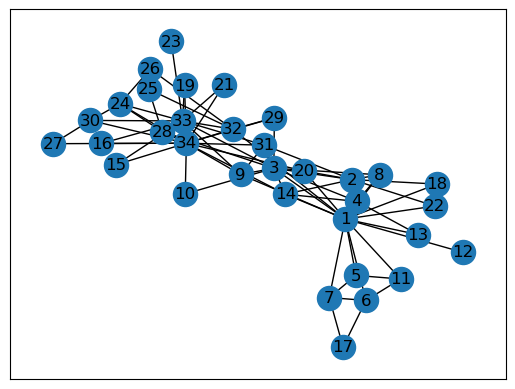

In [1]:
import networkx as nx
import numpy as np
import random

G=nx.read_adjlist("data/karate_edges_77.txt",nodetype=int)
nx.draw_networkx(G,pos=nx.spring_layout(G))


EGOS [node 1, node 2, ...., node n]

ALTER [friend 1, None, ..., friend n]

In [4]:
def get_seeds(g, p, method):
    #NOTE: the proportion p should not be too high. otherwise there'll be lots of nodes with No available alters
    if method not in ['random', 'friend','pair']:
        raise ValueError("invalid input")

    num_seeds = int(p*g.number_of_nodes()) #number of egos
    samp = random.sample(list(g.nodes()), k = num_seeds) #sample egos w/out replacement
    
    if method == "random":
        return samp

    #{node: friend} dict
    friend_dict  = dict.fromkeys(samp) #initialise as {node: None, ...}

    samp_degrees = dict(G.degree(samp))#degrees of the egos

    #consider egos in ascending order of degree. to deal with edge cases 
    # \              
    # -(x)-()-(x) 
    nodes_by_degree = [k for k, v in sorted(samp_degrees.items(), key=lambda item: item[1])]

    print("node, available friends:")
    for n in nodes_by_degree:
        friends = list(g.adj[n])
        available_f = [f for f in friends
            if f not in list(friend_dict.values())
            and f not in list(friend_dict.keys())] #friends that are not alters or egos
        print(n,available_f)

        if len(available_f) > 0:
            friend_dict[n] = random.choice(available_f) #randomly assign one of the alters as friend          

    print("\nresulting seeding:")
    print(friend_dict) 

    #try to replace egos that don't have alters. 
    # -(x)-(x), sometimes, even going in ascending order not enough. 
    for n in list(friend_dict.keys()):
        if friend_dict[n] is None:
            replacements = [n for n in list(g.nodes()) if 
                n not in (list(friend_dict.values()) + list(friend_dict.keys()))]
            print("\nreplacements")
            print(n, replacements)

            random.shuffle(replacements) #shuffle the order
            for r in replacements:
                #SAME AS ABOVE
                friends = list(g.adj[r])
                available_f = [f for f in friends if f not in list(friend_dict.values()) and f not in list(friend_dict.keys())] #friends that are not alters or egos
                
                if len(available_f) > 0:
                    friend_dict[r] = random.choice(available_f) #make new key for replacement
                    friend_dict.pop(n, None) #remove old ego that didn't have alter
                    print("{} replaced {}".format(r,n))
                    break

            if n in list(friend_dict.keys()): # if n is still in the list
                raise Exception('unable to find replacement for node',n)

    print("\nfinal dict:")
    print(friend_dict)

    if method == 'friend':
        return list(friend_dict.values())

    else:#method pair
        half_keys = random.sample(list(friend_dict.keys()), 
                        k = int(len(friend_dict.keys())/2)) #sample half the keys
        half_values = [friend_dict[k] for k in half_keys]#their corresponding values
        return half_keys + half_values
    

In [26]:
seeds = get_seeds(G, 0.2, 'pair')
seeds# the final targeted nodes, by whichever method (random, pair, friend)

node, available friends:
15 [34]
20 [2]
31 []
9 [3]
33 [16, 19, 21, 23, 24, 30, 32]
1 [4, 5, 6, 7, 8, 11, 12, 13, 14, 18, 22, 32]

resulting seeding:
{31: None, 20: 2, 1: 18, 9: 3, 15: 34, 33: 24}

replacements
31 [4, 5, 6, 7, 8, 11, 12, 13, 14, 22, 32, 10, 28, 29, 17, 16, 19, 21, 23, 26, 30, 25, 27]
4 replaced 31

final dict:
{20: 2, 1: 18, 9: 3, 15: 34, 33: 24, 4: 13}


[15, 9, 4, 34, 3, 13]

## simulating seeds

In [13]:
#counts of how many times the node got selected as seed. If want mean, sd, use lists. 
random_counts = dict.fromkeys(G.nodes(), 0)
friend_counts = dict.fromkeys(G.nodes(), 0)
pair_counts = dict.fromkeys(G.nodes(), 0)

n_samples = 1000
p = 0.2

for i in range(n_samples):
    random_samp = get_seeds(G, p, 'random')
    friend_samp = get_seeds(G, p, 'friend')
    pair_samp = get_seeds(G, p, 'pair')

    for node in random_samp:
        random_counts[node] += 1
    for node in friend_samp:
        friend_counts[node] += 1
    for node in pair_samp:
        pair_counts[node] += 1


node, available friends:
12 [1]
19 [34]
20 [2]
14 [4]
3 [8, 9, 10, 28, 29]
33 [9, 15, 16, 21, 23, 24, 30, 31, 32]

resulting seeding:
{20: 2, 19: 34, 14: 4, 12: 1, 3: 10, 33: 16}

final dict:
{20: 2, 19: 34, 14: 4, 12: 1, 3: 10, 33: 16}
node, available friends:
22 [1, 2]
15 [33, 34]
19 [34]
20 [1]
31 [9]
7 [5, 6, 17]

resulting seeding:
{20: 1, 31: 9, 22: 2, 7: 5, 15: 33, 19: 34}

final dict:
{20: 1, 31: 9, 22: 2, 7: 5, 15: 33, 19: 34}
node, available friends:
10 [34]
21 [33]
25 [26, 28, 32]
20 [1, 2]
14 [2, 4]
3 [4, 8, 9, 28, 29]

resulting seeding:
{10: 34, 3: 9, 21: 33, 25: 32, 20: 1, 14: 2}

final dict:
{10: 34, 3: 9, 21: 33, 25: 32, 20: 1, 14: 2}
node, available friends:
19 [33, 34]
15 [34]
13 [1, 4]
5 [1, 7, 11]
20 [2]
3 [8, 9, 10, 14, 28, 29]

resulting seeding:
{19: 33, 3: 8, 5: 1, 15: 34, 13: 4, 20: 2}

final dict:
{19: 33, 3: 8, 5: 1, 15: 34, 13: 4, 20: 2}
node, available friends:
13 [1]
11 [5, 6]
30 [24, 27, 33, 34]
7 [5, 17]
4 [3, 8, 14]
2 [3, 14, 18, 20, 22, 31]

resulting

In [27]:
#turn to simulated probabilities
random_probs = {k:v/n_samples for (k,v) in sorted(random_counts.items(), key=lambda item: item[1], reverse = True)}
friend_probs = {k:v/n_samples for (k,v) in sorted(friend_counts.items(), key=lambda item: item[1], reverse = True)}
pair_probs = {k:v/n_samples for (k,v) in sorted(pair_counts.items(), key=lambda item: item[1], reverse = True)}

random_probs

{6: 0.203,
 7: 0.193,
 5: 0.192,
 18: 0.187,
 25: 0.187,
 31: 0.185,
 3: 0.184,
 9: 0.184,
 14: 0.183,
 4: 0.182,
 28: 0.182,
 15: 0.182,
 33: 0.181,
 8: 0.18,
 10: 0.18,
 1: 0.179,
 20: 0.179,
 32: 0.178,
 21: 0.177,
 26: 0.176,
 2: 0.174,
 11: 0.173,
 12: 0.173,
 22: 0.171,
 30: 0.171,
 27: 0.17,
 13: 0.169,
 19: 0.168,
 23: 0.168,
 16: 0.164,
 34: 0.158,
 17: 0.157,
 29: 0.155,
 24: 0.155}